### Домашнее задание

In [1]:
!pip install shap

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install catboost

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install imblearn

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm.auto import tqdm
from xgboost import XGBClassifier, XGBModel
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, classification_report, recall_score, accuracy_score, \
        r2_score

tqdm.pandas()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Вспомогательные функции и классы

In [5]:

def df_overview(df, ascateg=[], cols=2, size=(12, 12)):
    """ Функция выводит обзорные графики колонок датасета в виде сетки с кол-вом колонок cols """
  
    n = len(df.columns)
    
    if n % cols == 0:
        rows = n // cols
    else:
        rows = n // cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=size)
   
    # скроем все сетки
    for ax in axs.ravel():
        ax.axison = False
        
    for feat, ax in tqdm(zip(df.columns, axs.ravel())):
      
        ax.axison = True
        if df[feat].dtype == 'object' or feat in ascateg:
            sns.countplot(data=df, x=feat, ax=ax)
        else:
            # sns.jointplot(data=DF, x=feature, y='Exited', kind="reg", truncate=False)
            sns.histplot(data=df, x=feat, kde=True, ax=ax)
        ax.set_xlabel(feat, fontsize=10)
        ax.set_ylabel("Count", fontsize=9)
        ax.tick_params(labelsize=6)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def get_feature_names_out(self, feature_names_out):
        return self.columns
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, dtype=np.int8)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
def metric_calculation(y_test: np.ndarray, y_predict: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    print(f'Metrics:')
    
    # r2 = r2_score(y_test, y_predict)
    # print(f"R2 (коэфф. детерминации): {r2}")
    
    acc = accuracy_score(y_test, y_predict)
    print(f"Accuracy: {acc}") 
    
    f1 = f1_score(y_test, y_predict)
    print(f"F1: {f1}") 
    
    roc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc}") 
    
    rec = recall_score(y_test, y_predict)
    print(f"Recall: {rec}") 
    
    prc = precision_score(y_test, y_predict)
    print(f"Precision: {prc}") 
    
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    return {"accuracy": acc, "f1 score": f1, "roc-auc score": roc, "recal score": rec, "precision score": prc, "conf_matrix": cm}

In [8]:
def plot_precision_recall_curve(y_true, y_pred_score, beta=1):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    
    if np.isnan(fscore).any():
        fscore = np.nan_to_num(fscore, nan=0.0)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
        
    print(f"Best Threshold={thresholds[ix]}", 
        f"F-Score={fscore[ix]:.03f}",
        f"Beta={beta}", 
        f"Precision={precision[ix]:.03f}", 
        f"Recall={recall[ix]:.03f}")

    plt.figure(figsize=(9, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=plt.gca())
    
    plt.axvline(recall[ix], color="red", alpha=1, ls="--", 
                label=f"Recall={recall[ix]:.03f}")
    
    plt.axhline(precision[ix], color="red", alpha=1, ls="-.",
                label=f"Precision={precision[ix]:.03f}")
    plt.title(f"Precision-recall кривая (Max F-score: {fscore[ix]:.03f} beta={beta})")
    plt.legend()
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return precision, recall, thresholds, fscore, ix

def plot_roc_auc_curve(y_true, y_pred_score):
    score = roc_auc_score(y_true, y_pred_score)
    print(f"ROC-AUC score: {score:.03f}")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    plt.figure(figsize=(9, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
    plt.title(f"ROC-AUC кривая (Score: {score:.03f})")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return score
    
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    plt.figure(figsize=(9, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=plt.gca(), cmap='cividis')
    plt.title("Матрица ошибок")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return cm

## Описание датасета

Для выполнения задания выбран датасет для бинарной классификации: https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

Этот набор данных содержит 253680 ответов на опрос из очищенного BRFSS 2015.

BRFSS - Система наблюдения за поведенческими факторами риска, которая представляет собой телефонный опрос, связанный со здоровьем, ежегодно собираемый CDC. Ежегодно (с 1984 года), в рамках опроса, собираются ответы более 400 000 американцев о рискованном для здоровья поведении, хронических заболеваниях и использовании профилактических услуг.

Датасет содержит:

* одну бинарную целевую переменную: HeartDiseaseorAttack 
* 21 функциональную переменную


## Загрузка данных

In [9]:
DF = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv", delimiter=",")
DF

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


## EDA

### Обзор датасета

In [10]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [11]:
DF.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


22it [00:08,  2.49it/s]


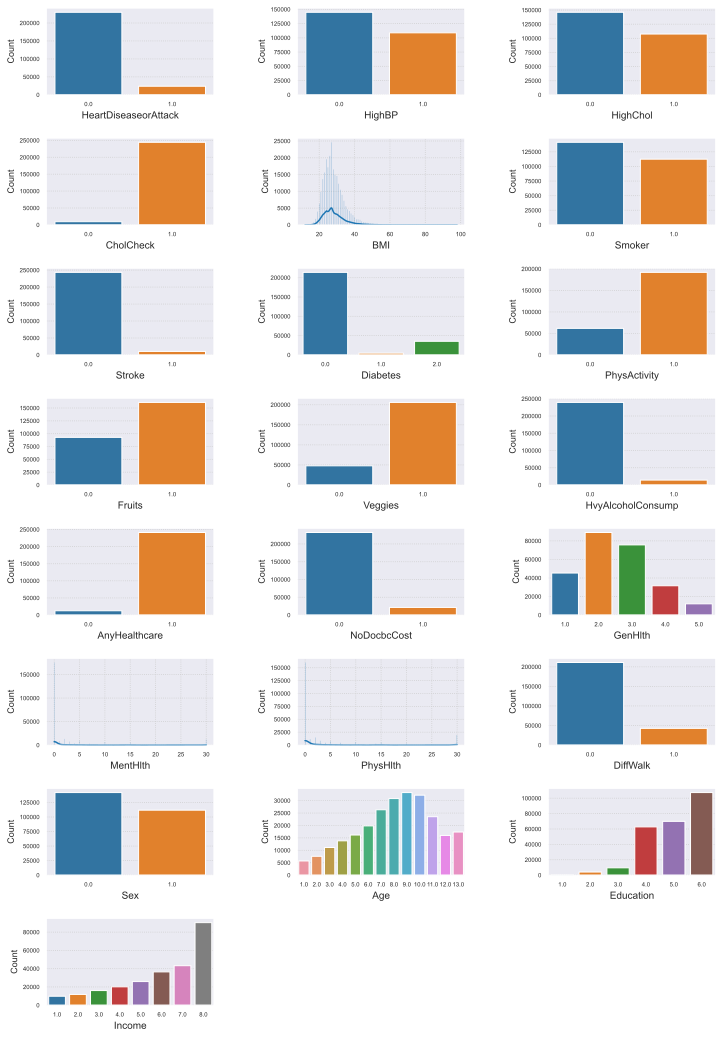

In [12]:
show_as_categ = ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes', 
                 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'] 
df_overview(DF, ascateg=show_as_categ, cols=3, size=(12, 18))

Замечания на основании обзора датасета: 

* данные подготовлен, очищены и приведены к нужному типу

* возраст пациентов в датасете разбит на 14 групп. Поле Age - это группа возраста.

* сильный дисбаланс классов у целевой переменной (HeartDiseaseorAttack).

* разреженность многих признаков (CholCheck, Stroke, AnyHealthCare, MentHlth, PhysHlth, ...)

### Проверим корреляцию признаков

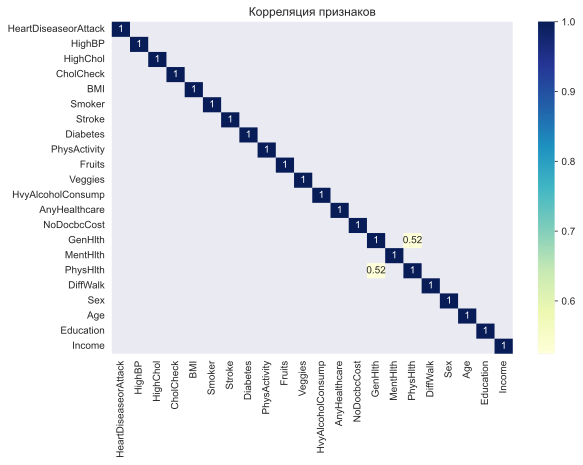

In [13]:
corr = DF.corr()
filt_corr = corr[np.abs(corr) >= 0.5]

plt.figure(figsize=(9, 6))
sns.heatmap(filt_corr, cmap="YlGnBu", annot=True)
plt.title("Корреляция признаков")
plt.show()

Есть линейно-зависимые признаки: PhysHlth-GenHlth

## Разделение датасета на тренировочную и валидационную часть

In [14]:
FEATS = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
         'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income', 'Age', 'MentHlth', 'BMI'] # 'PhysHlth',
# FEATS = ['HighBP', 'HighChol', 'Smoker', 'Diabetes', 'PhysActivity', 'HvyAlcoholConsump', 'MentHlth', 'PhysHlth', 'Sex', 'Income', 'Age', 'BMI']
TARGET = 'HeartDiseaseorAttack'

X_train, X_test, y_train, y_test = train_test_split(DF[FEATS], DF[TARGET], test_size=0.3, stratify=DF[TARGET], random_state=42)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(DF, DF['HeartDiseaseorAttack'],
                                                    test_size=0.33, random_state=42)
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

## Пайп-лайн

In [16]:
categ_feats = [] # FEATS[:-4]
bin_feats = []  # FEATS[:-1]
scaler_feats = FEATS  # ['Age', 'MentHlth', 'PhysHlth', 'BMI']  # ['BMI']

Опробуем разные классификаторы

In [17]:
# выбранный классификатор
# CatBoostClassifier XGBClassifier RandomForestClassifier BaggingClassifier LogisticRegression DecisionTreeClassifier

classifier = 'XGBClassifier' 

In [18]:
TRANSFORMERS = []

for col in bin_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col))])))

for col in scaler_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))

for col in categ_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('ohe', OHEEncoder(key=col))])))

vc = y_train.value_counts()
scale_pos_weight = int(vc[0] / vc[1])

print(f"Соотношение классов '0' и '1': {scale_pos_weight}")

clf_params = {
    'CatBoostClassifier': {
        'loss_function': 'Logloss',
        'auto_class_weights': 'Balanced',
        'depth': 6,
        'iterations': 300,
        'learning_rate': 0.01,
        'eval_metric': 'AUC',
        'verbose': 200
    },
    'XGBClassifier': {
        'verbosity': 1,
        'max_depth': 5,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform', # 'gradient_based', 'uniform'
        'scale_pos_weight': scale_pos_weight 
    },
    'RandomForestClassifier': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'gini',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    },
    'BaggingClassifier': {
        'n_jobs': -1,
        'n_estimators': 10,
        'verbose': 1
    },
    'DecisionTreeClassifier': {
        'criterion': 'gini',
        'max_depth': 7,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'class_weight': 'balanced',
          
    },
    'LogisticRegression': {
        'max_iter': 1000,
        'class_weight': 'balanced', # {0:1, 1:10}
        'fit_intercept': True, 
        'penalty': 'l2'
    }
}

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])
# опробуем метод сокращения кол-ва фичей
# PIPELINE.steps.append(('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))))

# выбор нужного классификатора
if classifier == 'CatBoostClassifier':
    PIPELINE.steps.append(('clf', CatBoostClassifier(random_state=42, **clf_params['CatBoostClassifier'])))
elif classifier == 'XGBClassifier':
    PIPELINE.steps.append(('clf', XGBClassifier(random_state=42, **clf_params['XGBClassifier'])))
elif classifier == 'RandomForestClassifier':
    PIPELINE.steps.append(('clf', RandomForestClassifier(random_state=42, **clf_params['RandomForestClassifier'])))
elif classifier == 'BaggingClassifier':
    PIPELINE.steps.append(('clf', BalancedBaggingClassifier(random_state=42, **clf_params['BaggingClassifier'])))
elif classifier == 'DecisionTreeClassifier':
    PIPELINE.steps.append(('clf', DecisionTreeClassifier(random_state=42, **clf_params['DecisionTreeClassifier'])))
else:
    PIPELINE.steps.append(('clf', LogisticRegression(random_state=42, **clf_params['LogisticRegression'])))

PIPELINE.verbose = True


# тренировка 
PIPELINE.fit(X_train, y_train)


Соотношение классов '0' и '1': 9
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   8.5s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('HighBP',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighBP')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('HighChol',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighChol')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('CholCheck',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='CholCheck')),
                                                                 ('scaler',
                                                                  St...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))],
         verbose=True)

In [19]:
PIPELINE.steps

[('features',
  FeatureUnion(transformer_list=[('HighBP',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(key='HighBP')),
                                                  ('scaler', StandardScaler())])),
                                 ('HighChol',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(key='HighChol')),
                                                  ('scaler', StandardScaler())])),
                                 ('CholCheck',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(key='CholCheck')),
                                                  ('scaler', StandardScaler())])),
                                 ('Smoker'...
                                                   FeatureSelector(key='Income')),
                            

In [20]:
!pip install flask-ngrok

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [21]:
!pip install dill

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [22]:
import dill

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

Сохраним модель (пайплайн)

In [23]:
with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(PIPELINE, f)

# Step 2 - PREDICT

### Проверка работоспособности и качества пайплайна

Здесь мы еще не запускаем никакое API, а загружаем модель (pipeline) напрямую и проверяем на отложенной (тестовой) выборке

In [24]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [25]:
X_test.head(5)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,3.0,7.0,0.0,0.0,7.0,4.0,2.0
1,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,6.0,6.0
2,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0
3,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,4.0,7.0
4,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,27.0,27.0,1.0,0.0,8.0,3.0,2.0


In [26]:
X_test.iloc[2]

HeartDiseaseorAttack     0.0
HighBP                   0.0
HighChol                 0.0
CholCheck                1.0
BMI                     24.0
Smoker                   0.0
Stroke                   0.0
Diabetes                 0.0
PhysActivity             1.0
Fruits                   1.0
Veggies                  1.0
HvyAlcoholConsump        0.0
AnyHealthcare            1.0
NoDocbcCost              0.0
GenHlth                  1.0
MentHlth                 0.0
PhysHlth                 0.0
DiffWalk                 0.0
Sex                      1.0
Age                      1.0
Education                4.0
Income                   7.0
Name: 2, dtype: float64

In [27]:
with open('logreg_pipeline.dill', 'rb') as in_strm:
    PIPELINE = dill.load(in_strm)

In [28]:
PIPELINE

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('HighBP',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighBP')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('HighChol',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighChol')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('CholCheck',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='CholCheck')),
                                                                 ('scaler',
                                                                  St...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))],
         verbose=True)

## Метрики

In [29]:
# получим вероятности принадлежности к классу '1'
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

In [30]:
len(y_test_pred_proba)

83715

In [31]:
X_test[:2]

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,3.0,7.0,0.0,0.0,7.0,4.0,2.0
1,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,6.0,6.0


In [32]:
PIPELINE.predict_proba(X_test[:2])

array([[0.93434364, 0.06565638],
       [0.3042782 , 0.6957218 ]], dtype=float32)

In [33]:
y_test_pred_proba[:10]

array([6.5656379e-02, 6.9572181e-01, 4.1539731e-04, 1.3208960e-02,
       6.6432297e-01, 4.1518670e-01, 4.2011535e-01, 7.1270442e-01,
       3.3718443e-01, 1.6581923e-01], dtype=float32)

In [34]:
pred_df1 = pd.DataFrame({'preds': y_test_pred_proba})
pred_df1

,preds
0,0.065656
1,0.695722
2,0.000415
3,0.013209
4,0.664323
...,...
83710,0.006776
83711,0.006820
83712,0.369599
83713,0.205613


In [35]:
#pred_df = pd.DataFrame({'preds': y_test_pred_proba})
#pred_df.to_csv("test_predictions.csv", index=None)

Т.к. датасет создан для предсказания сердечно-сосудистых заболеваний, то лучше максимизировать recall, т.е. меньше пропускать действительно больных.
Поэтому, "сдвинем" параметр beta метрики f-score. 
 

Best Threshold=0.5935664772987366 F-Score=0.473 Beta=1.5 Precision=0.276 Recall=0.694


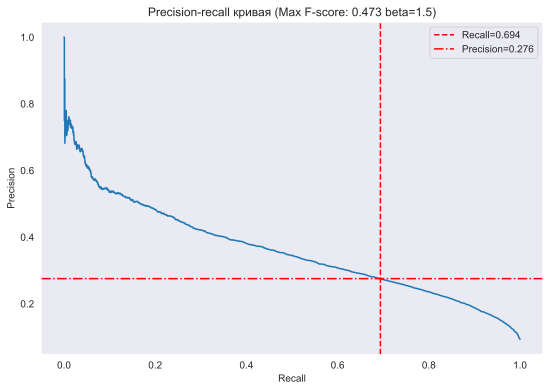

In [36]:
beta = 1.5
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

In [37]:
y_test_pred = y_test_pred_proba > thresholds[ix]

In [38]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.8004419757510601
F1: 0.39444686095403797
ROC-AUC: 0.8407211178810559
Recall: 0.6937396404437077
Precision: 0.27556343378070397
Confusion matrix: TN=61568 FP=14304 FN=2402 TP=5441


ROC-AUC score: 0.841


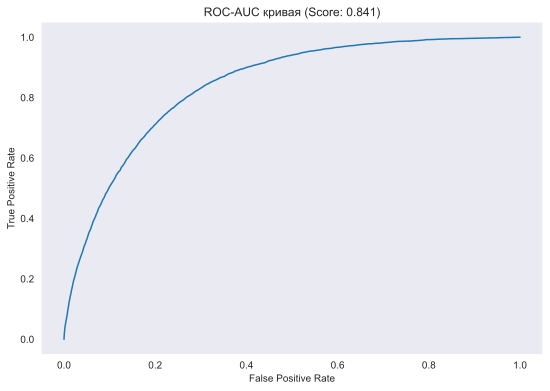

In [39]:
auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

## Важность признаков

In [40]:
feature_names = list(PIPELINE.named_steps['features'].get_feature_names_out())

# if PIPELINE.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
if hasattr(PIPELINE.named_steps['clf'], 'feature_importances_'):
    feature_coeff = PIPELINE.named_steps['clf'].feature_importances_
else:
    feature_coeff = PIPELINE.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({'feature_name': feature_names, 
                                   'feature_score': feature_coeff
                                   }).sort_values('feature_score', ascending=False).reset_index(drop=True)
feature_importance

,feature_name,feature_score
0,HighBP__HighBP,0.289869
1,GenHlth__GenHlth,0.110324
2,HighChol__HighChol,0.083944
3,Stroke__Stroke,0.073074
4,Age__Age,0.071896
5,Sex__Sex,0.067294
6,DiffWalk__DiffWalk,0.054677
7,Diabetes__Diabetes,0.045209
8,Smoker__Smoker,0.036191
9,CholCheck__CholCheck,0.017071


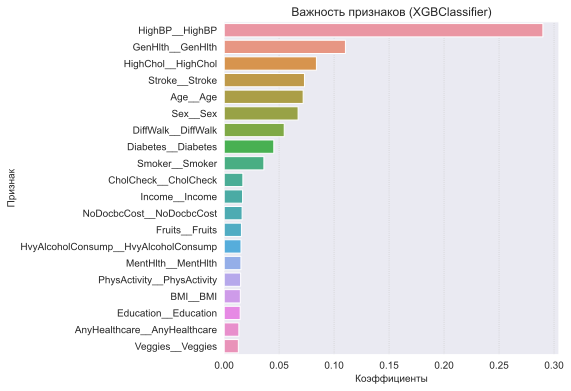

In [41]:
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, y='feature_name', x='feature_score')
plt.ylabel("Признак")
plt.xlabel("Коэффициенты")
plt.title(f"Важность признаков ({PIPELINE.named_steps['clf'].__class__.__name__})")
plt.show()

Так как для нас важны следующие фичи для диагностирования heartattack:

1. MentHlth - сюда входят: стрессы, депрессии, эмоциональные растройства

2. Высокое давление HighBP

2. Курение Smoker

3. Диабет Diabetes

4. Повышенный холестерин HighChol

5. Трудности при ходьбе DiffWalk

6. Высокий возраст


То для запроса важно передовать хотя бы первые 2-3 признака.

# Step 3 - FLASK

## При внедрении

**При внедрении необходимо сделать:**
*   Определить формат json'а, в котором данные будут приниматься сервисом и отправляться обратно.
*   Определить ip-адрес и порт, на который будут поступать данные.
*   Создать во Flask необходимые роуты:<br/>
    `@app.route('/predict_example', method='POST')`<br/>
    `def predict_example():`
*   Перенести во Flask все функции преобразования данных,
    *   формат данные, приходящих от фронт-системы, может отличаться от формата исторических данных, использовавшихся при построении модели; в результате преобразований данные на вход модели должны поступить ровно в том виде, в каком была обучена модель.
*   Загрузить обученные модели.
*   Настроить логирование.

## Flask

Тут будет сервис для обработки запросов на Flask

Google Colab предоставляет виртуальную машину, поэтому мы не можем получить доступ к локальному хосту, как это делаем на нашем локальном компьютере при запуске локального веб-сервера. Что мы можем сделать, так это предоставить его общедоступному URL-адресу с помощью ngrok.

https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b

In [42]:
from flask import Flask, request, jsonify

In [43]:
import json

### **Создаем сервис для обработки запросов к модели**

In [44]:
# Загружаем обученные модели
with open('logreg_pipeline.dill', 'rb') as in_strm:
    model = dill.load(in_strm)

In [45]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

Запустить сервис и не глушить его, пока работаем 

In [46]:
import numpy as np

In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    
    HighBP, HighChol, CholCheck, Smoker, Stroke, Diabetes, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex, Education, Income, Age, MentHlth, BMI = "","","","","","","","","","","","","","","","","","","",""
        
    #HighBP, HighChol, CholCheck = "","",""
 
    
    #description, company_profile, benefits = "", "", ""
    
    request_json = request.get_json()
    
    if request_json["HighBP"]:
        HighBP = np.float64(request_json['HighBP'])
    
    if request_json["HighChol"]:
        HighChol = np.float64(request_json['HighChol'])
                
    if request_json["CholCheck"]:
        CholCheck = np.float64(request_json['CholCheck'])
        
    if request_json["Smoker"]:
        Smoker = np.float64(request_json['Smoker'])
    
    if request_json["Stroke"]:
        Stroke = np.float64(request_json['Stroke'])
                
    if request_json["Diabetes"]:
        Diabetes = np.float64(request_json['Diabetes'])
        
    if request_json["PhysActivity"]:
        PhysActivity = np.float64(request_json['PhysActivity'])
    
    if request_json["Fruits"]:
        Fruits = np.float64(request_json['Fruits'])
                
    if request_json["Veggies"]:
        Veggies = np.float64(request_json['Veggies'])
 
    if request_json["HvyAlcoholConsump"]:
        HvyAlcoholConsump = np.float64(request_json['HvyAlcoholConsump'])
    
    if request_json["AnyHealthcare"]:
        AnyHealthcare = np.float64(request_json['AnyHealthcare'])
                
    if request_json["NoDocbcCost"]:
        NoDocbcCost = np.float64(request_json['NoDocbcCost'])
        
    if request_json["GenHlth"]:
        GenHlth = np.float64(request_json['GenHlth'])
    
    if request_json["DiffWalk"]:
        DiffWalk = np.float64(request_json['DiffWalk'])
                
    if request_json["Sex"]:
        Sex = np.float64(request_json['Sex'])

    if request_json["Education"]:
        Education = np.float64(request_json['Education'])
    
    if request_json["Income"]:
        Income = np.float64(request_json['Income'])
                
    if request_json["Age"]:
        Age = np.float64(request_json['Age'])

    if request_json["MentHlth"]:
        MentHlth = np.float64(request_json['MentHlth'])
                
    if request_json["BMI"]:
        BMI = np.float64(request_json['BMI'])
 
    
    #print(HighBP)
    #print(type(HighBP))
    #print(HighChol)
    #print(CholCheck)
    preds = model.predict_proba(pd.DataFrame({"HighBP": [HighBP],
                                              "HighChol": [HighChol],
                                              "CholCheck": [CholCheck],
                                              "Smoker":[Smoker],
                                              "Stroke":[Stroke],
                                              "Diabetes":[Diabetes],
                                              "PhysActivity":[PhysActivity],
                                              "Fruits":[Fruits],
                                              "Veggies":[Veggies],
                                              "HvyAlcoholConsump":[HvyAlcoholConsump],
                                              "AnyHealthcare":[AnyHealthcare],
                                              "NoDocbcCost":[NoDocbcCost],
                                              "GenHlth":[GenHlth],
                                              "DiffWalk":[DiffWalk],
                                              "Sex":[Sex],
                                              "Education":[Education],
                                              "Income":[Income],
                                              "Age":[Age],
                                              "MentHlth":[MentHlth],
                                              "BMI":[BMI]}))
    
        
    print(pd.DataFrame({"HighBP": [HighBP],
                                              "HighChol": [HighChol],
                                              "CholCheck": [CholCheck],
                                              "Smoker":[Smoker],
                                              "Stroke":[Stroke],
                                              "Diabetes":[Diabetes],
                                              "PhysActivity":[PhysActivity],
                                              "Fruits":[Fruits],
                                              "Veggies":[Veggies],
                                              "HvyAlcoholConsump":[HvyAlcoholConsump],
                                              "AnyHealthcare":[AnyHealthcare],
                                              "NoDocbcCost":[NoDocbcCost],
                                              "GenHlth":[GenHlth],
                                              "DiffWalk":[DiffWalk],
                                              "Sex":[Sex],
                                              "Education":[Education],
                                              "Income":[Income],
                                              "Age":[Age],
                                              "MentHlth":[MentHlth],
                                              "BMI":[BMI]}))
    print(f'Preds: {preds}')
    #print(preds[:, 1][0])
    
    data["predictions"] = np.float64(preds[:, 1][0])
    #data["HighBP"] = HighBP
        # indicate that the request was a success
    data["success"] = True
    print('Запрос прошел : OK!')
    
    #print(type(data["predictions"]))
    
    print(f'Data: {data}')
    #print(type(HighBP))

        # return the data dictionary as a JSON response
    
    return jsonify(data)
    


if __name__ == '__main__':
    app.run(port=8082)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8082
Press CTRL+C to quit
127.0.0.1 - - [21/Jul/2023 18:36:29] "POST //predict HTTP/1.1" 200 -


   HighBP  HighChol  CholCheck  Smoker  Stroke  Diabetes  PhysActivity  \
0     1.0       0.0        0.0     0.0     0.0       0.0           0.0   

   Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  \
0     0.0      0.0                0.0            0.0          0.0      0.0   

   DiffWalk  Sex  Education  Income  Age  MentHlth  BMI  
0       0.0  0.0        0.0     0.0  0.0       0.0  0.0  
Preds: [[0.99790084 0.00209917]]
Запрос прошел : OK!
Data: {'success': True, 'predictions': 0.002099166624248028}


127.0.0.1 - - [21/Jul/2023 18:36:43] "POST //predict HTTP/1.1" 200 -


   HighBP  HighChol  CholCheck  Smoker  Stroke  Diabetes  PhysActivity  \
0     1.0       1.0        1.0     0.0     0.0       2.0           0.0   

   Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  \
0     0.0      0.0                0.0            0.0          0.0      0.0   

   DiffWalk  Sex  Education  Income  Age  MentHlth  BMI  
0       0.0  0.0        0.0     0.0  0.0       0.0  0.0  
Preds: [[0.7849863 0.2150137]]
Запрос прошел : OK!
Data: {'success': True, 'predictions': 0.21501369774341583}


127.0.0.1 - - [21/Jul/2023 18:36:58] "POST //predict HTTP/1.1" 200 -


   HighBP  HighChol  CholCheck  Smoker  Stroke  Diabetes  PhysActivity  \
0     1.0       1.0        1.0     0.0     0.0       2.0           0.0   

   Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  \
0     0.0      0.0                0.0            0.0          0.0      0.0   

   DiffWalk  Sex  Education  Income  Age  MentHlth  BMI  
0       0.0  0.0        5.0     0.0  0.0       0.0  0.0  
Preds: [[0.5477469  0.45225307]]
Запрос прошел : OK!
Data: {'success': True, 'predictions': 0.4522530734539032}


127.0.0.1 - - [21/Jul/2023 18:37:23] "POST //predict HTTP/1.1" 200 -


   HighBP  HighChol  CholCheck  Smoker  Stroke  Diabetes  PhysActivity  \
0     1.0       1.0        1.0     1.0     1.0       2.0           0.0   

   Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  \
0     0.0      0.0                0.0            0.0          0.0      0.0   

   DiffWalk  Sex  Education  Income  Age  MentHlth  BMI  
0       0.0  0.0        5.0     0.0  0.0       0.0  0.0  
Preds: [[0.09037471 0.9096253 ]]
Запрос прошел : OK!
Data: {'success': True, 'predictions': 0.9096252918243408}
